# Retention : Measuring Performance
* StellarAlgo Data Science
* Ryan Kazmerik & Grant Donst
* February 3, 2023

This notebook attempts to measure the performance of our Retention model scores by comparing each quartile of scores to see how many fans actually renewed their product package.

In [2]:
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from data_sci_toolkit.aws_tools import permission_tools 
from data_sci_toolkit.aws_tools import redshift_tools
from data_sci_toolkit.common_tools import config_tools
from datetime import datetime, timedelta

/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
session = permission_tools.get_aws_session("US-StellarSupport")

Authorized as AROAUSMVSGV62RMB5U6S5:rkazmerik@stellaralgo.com


In [4]:
# Set team to be scored
SUBTYPE = "MLS-Dynamo"
params = config_tools.get_team_config(SUBTYPE, True)
CLIENTCODE = params["client_configs"][0]["clientcode"]

### Let's load up a list of retention scores we predicted in October of 2022 on what fans would renew their package:

In [5]:
S3_PATH = f"s3://us-curated-data-sci-retention-us-east-1-5h6cml/date=2022-12-31/{CLIENTCODE}/scores.csv"

In [6]:
df_scores = wr.s3.read_csv(boto3_session=session, path=S3_PATH, path_suffix=[".csv"])
df_scores.shape

(2826, 9)

In [7]:
df_scores["product"].value_counts()

Full Season     2257
Partial Plan     569
Name: product, dtype: int64

### Let's limit the scores to just the Full Season product plan for this experiment:

In [8]:
df_scores = df_scores[df_scores["product"]=="Full Season"]

### Let's visualize the distrubution of scores:

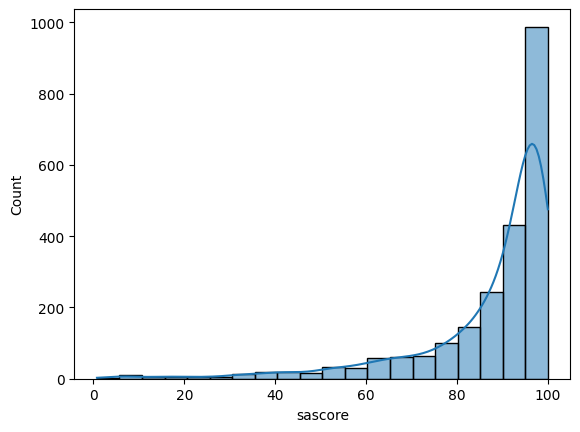

In [9]:
sns.histplot(data=df_scores, x='sascore', bins=20, kde=True);

### Now let's grab a list of customers that have already renewed their product for the 2023 season:

In [10]:
df = redshift_tools.get_retention_dataset(
    cluster = params["client_configs"][0]["cluster"],
    database = params["client_configs"][0]["dbname"],
    lkupclientid = params["client_configs"][0]["lkupclientid"],
    start_year = 2022,
    end_year = 2023
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(19075, 24)

### Let's limit to the Full Season product plan buyers again:

In [11]:
df = df[df["productgrouping"]=="Full Season"]

In [12]:

df.groupby(['year', 'productgrouping', 'isnextyear_buyer']).agg({
    "isnextyear_buyer":"count"
})

isnextyear_buyer
year productgrouping isnextyear_buyer                  
2022 Full Season     0                              363
                     1                             1894

### The table above shows us that 1894 fans have renewed their Full Season package for the 2023 season already, and 363 have not.

### Now let's join the Retention scores we predicted with the renewers from the season, so we can see how many of our predictions overlap with the fans who actually renewed:

In [13]:
df_renewers = df[df["isnextyear_buyer"]==1]
df_renewers.shape

(1894, 24)

In [14]:
df_join = df_scores.merge(df_renewers, on="dimcustomermasterid", how="inner")
df_join.shape

(1658, 32)

### In the chart below, we can see that as the predicted score increases, so does the number of fans who renewed:

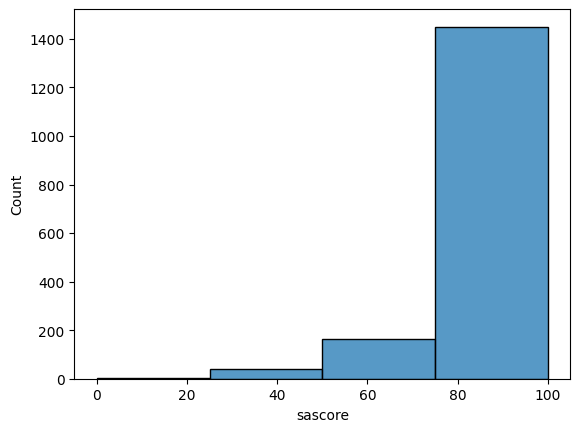

In [15]:
# Non normalized plot of sascore
sns.histplot(data=df_join, x='sascore', bins=[0,25,50,75,100]);

### Next we will normalize the results against how many scores were provided in each quartile (0-25, 25-50, 50-75, 75-100) by dividing the number of fans scored in each quartile by the number of fans who renewed in each quartile:

<AxesSubplot:xlabel='quartile', ylabel='percentage'>

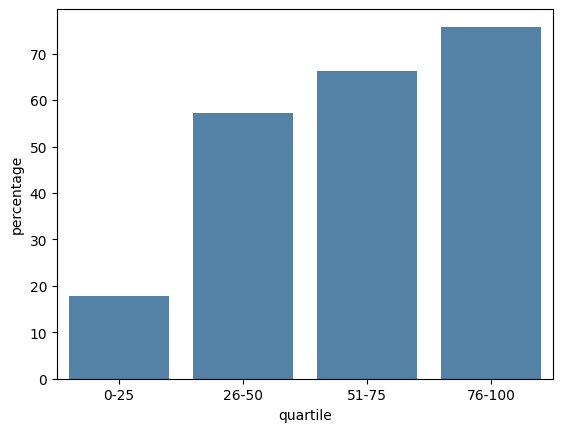

In [17]:
# Create quartiles
df_scores['quartile'] = pd.cut(df_scores['sascore'], [0, 25, 50, 75, 100], labels = ["0-25", "26-50", "51-75", "76-100"])

merged_df = df_scores.merge(df[['dimcustomermasterid', 'isnextyear_buyer']], on='dimcustomermasterid', how='left')

# Filter the data to include only rows where 'isnextyear_buyer' is 1
filtered_df = merged_df[merged_df['isnextyear_buyer'] == 1]

# Group by quartiles
grouped = df_scores.groupby('quartile').size().reset_index(name='count')

# Calc the percentage of 'isnextyear_buyer' that is 1 for each quartile
grouped = grouped.merge(filtered_df.groupby('quartile').size().reset_index(name='filtered_count'), on='quartile')
grouped['percentage'] = grouped['filtered_count'] / grouped['count'] * 100

sns.barplot(x='quartile', y='percentage', data=grouped, color="steelblue")


### The chart above tells us that regardless of how many fans were predicted in each bucket, a higher score correlates to more fans renewing.

In [18]:
# Count is total number of accounts in that quartile, 
# filtered_count is total number of renewers per quartile bucket
print(grouped)

  quartile  count  filtered_count  percentage
0     0-25     28               5   17.857143
1    26-50     70              40   57.142857
2    51-75    246             163   66.260163
3   76-100   1913            1450   75.797177


### We can see that the 4th quartile (fans who received scores between 75 and 100) have over 75% rate of renewal.

# Comparing to Alternate Strategies

### Suppose for budgetary constraints, we could only pick 1,000 fans for renewal? Let's test some alternate strategies and see their renewal percentages:

### Strategy 1 : Pick 1000 Random Fans

### Strategy 2 : Pick 1000 Top Spend Fans

### Strategy 3 : Pick 1000 Top Tenured Fans